## Inverse Kinematics: Backward Shift, FABRIK, CCD 

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Arm:
    def __init__(self, _ax, _ay, _length, _angle):
        self.ax = _ax
        self.ay = _ay
        self.length = _length
        self.angle = _angle
        self.bx = self.ax + self.length * np.cos(self.angle)
        self.by = self.ay + self.length * np.sin(self.angle)

    def backward(self, tx, ty):
        theta = np.arctan2(ty - self.ay, tx - self.ax)
        self.ax = tx - self.length * np.cos(theta)
        self.ay = ty - self.length * np.sin(theta)
        self.bx = tx
        self.by = ty
        
    def forward(self, baseX, baseY):
        theta = np.arctan2(self.by - baseY, self.bx - baseX)
        self.ax = baseX
        self.ay = baseY
        self.bx = baseX + self.length * np.cos(theta)
        self.by = baseY + self.length * np.sin(theta)
    
    def shift(self, dx, dy):
        self.ax += dx
        self.ay += dy
        self.bx += dx
        self.by += dy

<IPython.core.display.Javascript object>


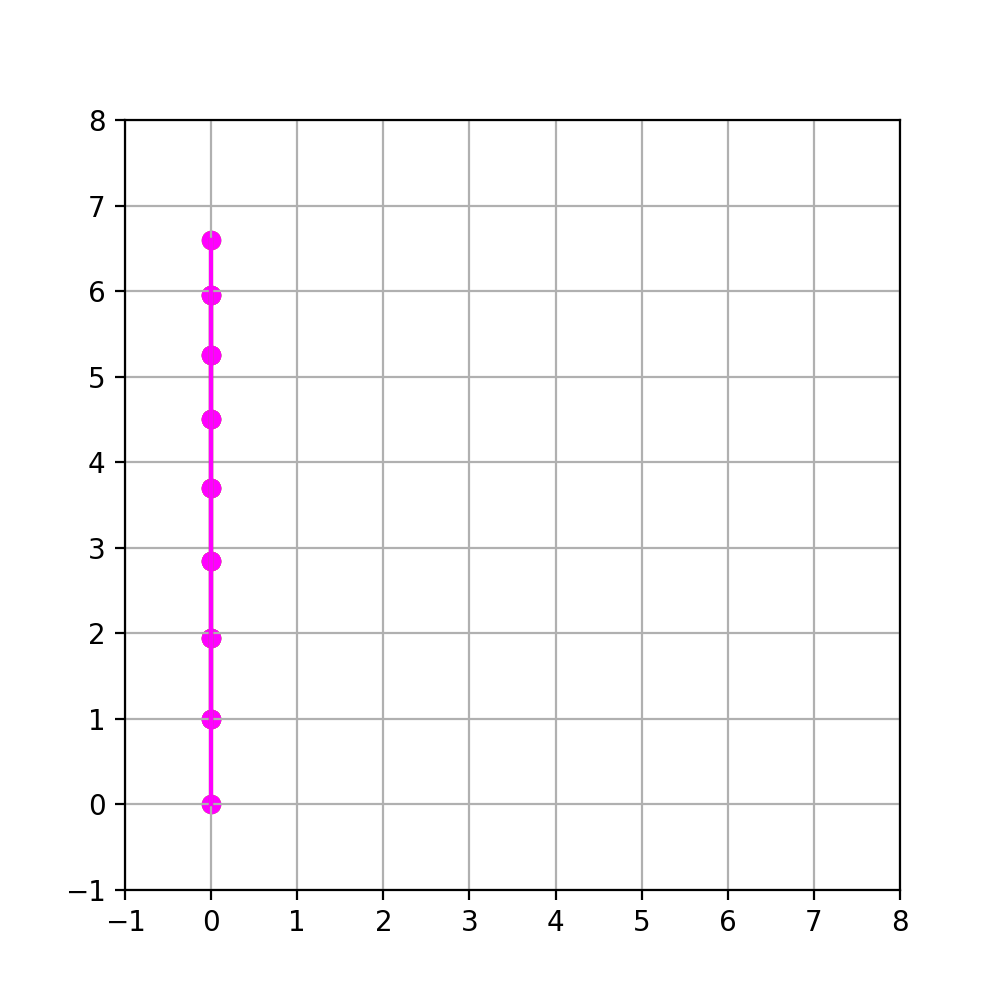

In [3]:
N = 8  # the number of link
OX = 0 # offset x
OY = 0 # offset y

bws = [] # Backward Shift
fab = [] # FABRIK
ccd = [] # CCD
for i in range(N):
    linkLength = 1 - i * 0.05
    initTheta = np.pi / 2
    if i == 0:
        bws.append(Arm(OX, OY, linkLength, initTheta))
        fab.append(Arm(OX, OY, linkLength, initTheta))
        ccd.append(Arm(OX, OY, linkLength, initTheta))
    else:
        bws.append(Arm(bws[i-1].bx, bws[i-1].by, linkLength, initTheta))
        fab.append(Arm(fab[i-1].bx, fab[i-1].by, linkLength, initTheta))
        ccd.append(Arm(ccd[i-1].bx, ccd[i-1].by, linkLength, initTheta))
        
bwsX = []
bwsY = []
fabX = []
fabY = []
ccdX = []
ccdY = []
for i in range(N):
    bwsX.append([bws[i].ax, bws[i].bx])
    bwsY.append([bws[i].ay, bws[i].by])
    fabX.append([fab[i].ax, fab[i].bx])
    fabY.append([fab[i].ay, fab[i].by])
    ccdX.append([ccd[i].ax, ccd[i].bx])
    ccdY.append([ccd[i].ay, ccd[i].by])
        
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N,-1,N])
ax.grid()
ax.plot(bwsX, bwsY, color='tab:blue')
ax.scatter(bwsX, bwsY, color='tab:blue')
ax.plot(fabX, fabY, color='orange')
ax.scatter(fabX, fabY, color='orange')
ax.plot(ccdX, ccdY, color='magenta')
ax.scatter(ccdX, ccdY, color='magenta')

In [4]:
# Backward + Zero shift
def Backward_Shift(arm, _tx, _ty):
    tx = _tx
    ty = _ty
    for i in reversed(range(N)):
        arm[i].backward(tx, ty)
        tx = arm[i].ax
        ty = arm[i].ay
    
    dx = OX - arm[0].ax
    dy = OX - arm[0].ay 
    PX = []
    PY = []
    for i in range(N):
        arm[i].shift(dx, dy)
        PX.append(arm[i].ax)
        PY.append(arm[i].ay) 
    PX.append(arm[N-1].bx)
    PY.append(arm[N-1].by)
    
    return PX, PY


# FABRIK: Backward + Forward
def FABRIK(arm, _tx, _ty):
    tx = _tx
    ty = _ty
    for i in reversed(range(N)):
        arm[i].backward(tx, ty)
        tx = arm[i].ax
        ty = arm[i].ay
    
    baseX = OX
    baseY = OY
    for i in range(N):
        arm[i].forward(baseX, baseY);
        baseX = arm[i].bx
        baseY = arm[i].by
        
    PX = []
    PY = []
    for i in range(N):
        PX.append(arm[i].ax)
        PY.append(arm[i].ay)  
    PX.append(arm[N-1].bx)
    PY.append(arm[N-1].by)
    
    return PX, PY


def CCD(arm, _tx, _ty):
    tx = _tx
    ty = _ty
    for i in reversed(range(N)):
        targetTheta = np.arctan2(ty - arm[i].ay, tx - arm[i].ax)
        endTheta = np.arctan2(arm[N-1].by - arm[i].ay, arm[N-1].bx - arm[i].ax)
        dTheta = targetTheta - endTheta;
        for j in range(i, N):
            linkTheta = np.arctan2(arm[j].by - arm[i].ay, arm[j].bx - arm[i].ax)
            linkDist = ((arm[j].bx - arm[i].ax)**2 + (arm[j].by - arm[i].ay)**2)**0.5
            arm[j].bx = arm[i].ax + linkDist * np.cos(dTheta + linkTheta)
            arm[j].by = arm[i].ay + linkDist * np.sin(dTheta + linkTheta)
            if j < N - 1:
                arm[j+1].ax = arm[j].bx
                arm[j+1].ay = arm[j].by
    
    PX = []
    PY = []
    for i in range(N):
        PX.append(arm[i].ax)
        PY.append(arm[i].ay)
    PX.append(arm[N-1].bx)
    PY.append(arm[N-1].by)
    
    return PX, PY
    

<IPython.core.display.Javascript object>


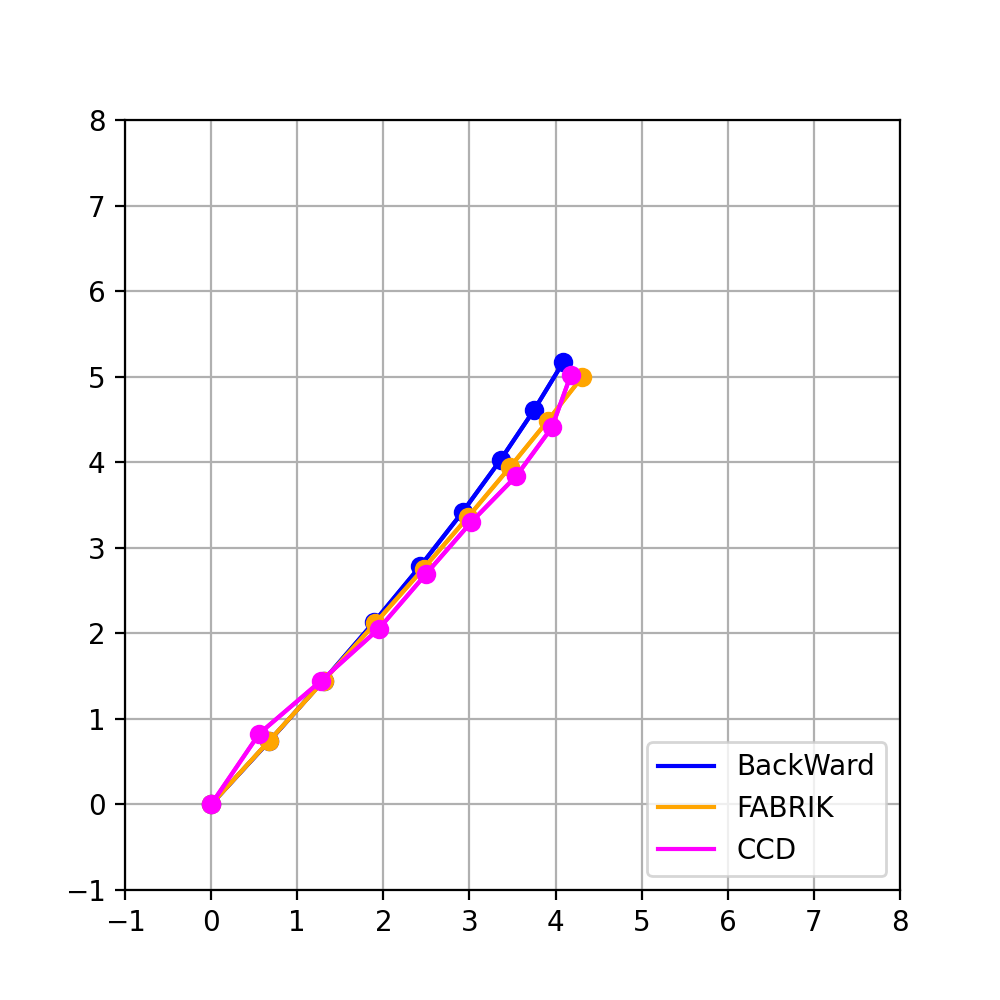

In [5]:
def motion(event):
    mx = event.xdata
    my = event.ydata
    Mouse.set_data(mx, my)
    
    BX, BY = Backward_Shift(bws, mx, my)
    BLine.set_data(BX, BY)
    BDot.set_data(BX, BY)
    
    FX, FY = FABRIK(fab, mx, my)
    FLine.set_data(FX, FY)
    FDot.set_data(FX, FY)
    
    CX, CY = CCD(ccd, mx, my)
    CLine.set_data(CX, CY)
    CDot.set_data(CX, CY)
    
    plt.draw()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N,-1,N])
ax.grid()

BLine, = ax.plot([],[], linestyle='-', color='blue', alpha=1, label='BackWard')
BDot, = ax.plot([],[], marker='o', color='blue')
FLine, = ax.plot([],[], linestyle='-', color='orange', alpha=1, label='FABRIK')
FDot, = ax.plot([],[], marker='o', color='orange')
CLine, = ax.plot([],[], linestyle='-', color='magenta', alpha=1, label='CCD')
CDot, = ax.plot([],[], marker='o', color='magenta')

Mouse, = ax.plot([],[], marker='x', ms=20, color='red')

plt.connect('motion_notify_event', motion)
plt.legend(loc='lower right')
plt.show()